In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

100% 1.14G/1.14G [00:36<00:00, 43.9MB/s]
100% 1.14G/1.14G [00:36<00:00, 33.3MB/s]


In [4]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
import keras 
print(keras.__version__)

2.4.3


In [7]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

import gdown
import zipfile

import os
import tensorflow as tf
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, Average

import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications import DenseNet121, ResNet50, VGG16

from imgaug import augmenters

from keras.models import Model, Input

In [8]:
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [9]:
batch_size = 32

img_height = 75
img_width = 75

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.2,shear_range=0.2,horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [11]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


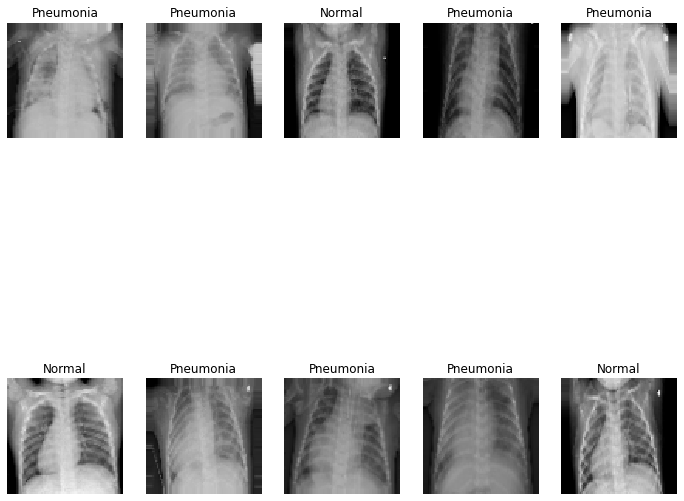

In [12]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [13]:
expert_conv_vgg = VGG16(weights = 'imagenet', include_top = False,input_shape=(img_width,img_height,3))

for layer in expert_conv_vgg.layers:
  trainable = True
  layer.trainable = trainable


expert_model_vgg = Sequential()
# expert_model.add(Reshape((64,64,3)))
expert_model_vgg.add(expert_conv_vgg)
expert_model_vgg.add(GlobalAveragePooling2D())

expert_model_vgg.add(Dense(128, activation = 'relu'))
expert_model_vgg.add(Dropout(0.3))
expert_model_vgg.add(Dense(64, activation = 'relu'))
expert_model_vgg.add(Dense(1, activation = "sigmoid"))

# opt = keras.optimizers.SGD(lr=1e-4, momentum=0.95)

# expert_model_vgg.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])

# expert_model_vgg.summary()

58892288/58889256 [==============================] - 1s 0us/step


In [14]:
expert_conv_resnet = ResNet50(weights = 'imagenet', include_top = False,input_shape=(img_width,img_height,3))

for layer in expert_conv_resnet.layers:
      trainable = True
      layer.trainable = trainable


expert_model_resnet = Sequential()
# expert_model.add(Reshape((64,64,3)))
expert_model_resnet.add(expert_conv_resnet)
expert_model_resnet.add(GlobalAveragePooling2D())

expert_model_resnet.add(Dense(128, activation = 'relu'))
expert_model_resnet.add(Dropout(0.3))
expert_model_resnet.add(Dense(64, activation = 'relu'))
expert_model_resnet.add(Dense(1, activation = "sigmoid"))

# opt = keras.optimizers.SGD(lr=1e-4, momentum=0.95)

# expert_model_resnet.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])

# expert_model_resnet.summary()

94773248/94765736 [==============================] - 1s 0us/step


In [15]:
expert_conv_densenet = DenseNet121(weights = 'imagenet', include_top = False,input_shape=(img_width,img_height,3))

for layer in expert_conv_densenet.layers:
      trainable = True
      layer.trainable = trainable


expert_model_densenet = Sequential()
# expert_model.add(Reshape((64,64,3)))
expert_model_densenet.add(expert_conv_densenet)
expert_model_densenet.add(GlobalAveragePooling2D())

expert_model_densenet.add(Dense(128, activation = 'relu'))
expert_model_densenet.add(Dropout(0.3))
expert_model_densenet.add(Dense(64, activation = 'relu'))
expert_model_densenet.add(Dense(1, activation = "sigmoid"))

# opt = keras.optimizers.SGD(lr=1e-4, momentum=0.95)

# expert_model_densenet.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])

# expert_model_densenet.summary()

29089792/29084464 [==============================] - 1s 0us/step


In [16]:
expert_model_vgg.load_weights('/content/drive/MyDrive/VGG16.h5')
expert_model_resnet.load_weights('/content/drive/MyDrive/ResNet50.h5')
expert_model_densenet.load_weights('/content/drive/MyDrive/densenet-121.h5')

models = [expert_model_vgg,expert_model_resnet,expert_model_densenet]

In [17]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score, log_loss
def test_model(model_list, test_set):
    output_list = []
    for m in model_list:
        output_list.append(m.predict_generator(test_set))
        
    output = sum(output_list)/len(model_list)
    
    y_bar = np.round(output).reshape(-1)
    y_act = test_set.labels
    ##accuracy
    print("Accuracy: ",accuracy_score(y_bar,y_act))
    ##Roc_Auc Score
    print("ROC-AUC score: ",roc_auc_score(y_bar,y_act))
    ##F1-Score Score
    print("F1 score: ",f1_score(y_bar,y_act))
    ##Log Loss Score
    print("Log Loss: ",log_loss(y_bar,y_act))
    
        

In [18]:
test_model(models, test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Accuracy:  0.9375
ROC-AUC score:  0.9435123876846103
F1 score:  0.9514321295143213
Log Loss:  2.1586837759310233
